In [804]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

data = pd.read_json('uebungsdatei.json')
data.tail()

,calEvents,datumBeginn,datumEnde,desc,gruppenName,name,newEvents,ort,score,speichern,uhrzeitBeginn,uhrzeitEnde,url
945,[],NaN,NaN,"[In Zeiten von Docker, Big Data und Microservi...",NaN,,[],,22,True,NaN,NaN,NaN
946,[],,,<p>Inhalt des 20. Info-Treffs</p> <p>C++ im Em...,C++ User Group Karlsruhe,C++ im Embedded-Medizinger�t � Lohnt der Einsa...,[],"Am Fasanengarten 5, Karlsruhe",23,True,,,https://www.meetup.com/C-User-Group-Karlsruhe/...
947,[],2018-08-16,2018-08-16,<p>Are you longing to hear and talk about that...,karlsruhe.ai,[Casual] Community Conversation about Machine ...,[],"Haid-und-Neu Str. 18, Karlsruhe, Karlsruhe",24,True,19:00,22:00,https://www.meetup.com/karlsruhe-ai/events/253...
948,[],,,<p>Die GDG Karlsruhe l�dt zum August-Meetup!</...,GDG Karlsruhe,GDG Karlsruhe August-Meetup,[],"Durlacher Allee 93, Karlsruhe",29,True,,,https://www.meetup.com/GDG-Karlsruhe/events/25...
949,[],2018-08-17,2018-08-17,<p>Blockchain is one of the most confusing ter...,Heidelberg Web Development & Ruby Meetup,Instaffo Blockchain-Day: Between Technology an...,[],"R�merstrasse 135, Heidelberg",33,True,17:00,21:00,https://www.meetup.com/Heidelberg-Web-Dev-Ruby...


In [805]:
data['speichern'].value_counts()

False    920
True      30
Name: speichern, dtype: int64

# HTML-Tags in Beschreibung entfernen

In [806]:
imp_data = data[['speichern','desc','gruppenName','name','ort']]

In [807]:
imp_data_plain = imp_data.copy()
imp_data_plain['desc']=imp_data['desc'].apply(lambda x : x.replace('"',''))
imp_data_plain['desc']=imp_data_plain.copy()['desc'].apply(lambda x : x.replace('<p>',''))
imp_data_plain['desc']=imp_data_plain.copy()['desc'].apply(lambda x : x.replace('</p>',''))
imp_data_plain['desc']=imp_data_plain.copy()['desc'].apply(lambda x : x.replace('<b>',''))
imp_data_plain['desc']=imp_data_plain.copy()['desc'].apply(lambda x : x.replace('</b>',''))
imp_data_plain['desc']=imp_data_plain.copy()['desc'].apply(lambda x : x.replace('\\n',''))
imp_data_plain['desc']=imp_data_plain.copy()['desc'].apply(lambda x : x.replace('\\>',''))
imp_data_plain['desc']=imp_data_plain.copy()['desc'].apply(lambda x : x.replace('/>',''))

In [808]:
imp_data_plain.head()

,speichern,desc,gruppenName,name,ort
0,False,[Technisches Verst�ndnis und Kenntnisse in der...,NaN,,
1,False,Kultur im Cyberspace und jugendliche Lebenswel...,NaN,,
2,False,[Kommunikation mit Computern ist wundervoll ei...,NaN,,
3,False,Talklet (Vortrags- und Diskussionsabend) am Do...,NaN,,
4,False,"[NOSQL, Big Data und Graphen sind zur Zeit in ...",NaN,,


# Datenset splitten

In [809]:
X_all = imp_data_plain.drop('speichern', axis=1)
Y_all = imp_data_plain["speichern"]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in sss.split(X_all, Y_all):
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    Y_train, Y_test = Y_all.iloc[train_index], Y_all.iloc[test_index]

# Beschreibungen vectorisieren und Vokabular anlegen

In [810]:
def isSubstantiv(x):
    x3 = ""
    xtemp = x.split(' ')
    for i in xtemp:
        if not i.islower() or i.isdigit() or i.isupper():
                x3 = x3 + " " + i
    return x3

X_train_voc =  X_train['desc'].apply(lambda x : isSubstantiv(x))

cv = TfidfVectorizer(token_pattern = '(?ui)\\b\\w*[a-z]\\w*[a-z]\\b',min_df=0.01, max_df = 0.75,max_features = 200)

cv.fit(X_train_voc)
X_train_cv = cv.transform(X_train['desc']).toarray()

In [811]:
len(X_train_voc)

760

In [812]:
X_train_voc

598     Talklet (Vortrags- Diskussionsabend) Donnerst...
867     [Nach Versuchen JavaFX Nachfolger Java Swing ...
269                                                  �� 
161                                   N�heres Anmeldung:
735     [The Java But If Clean Code Luckily In REST A...
389     In Vortrag Axel Fontaine Java Anwendungen Tag...
80                                                  Mehr
458     Sahaja Yoga Yogas, der�Selbstverwirklichung.�...
327     Treffen Ruby Rails-Machern KA Umgebung.\n\nVo...
273                                                     
587     Diese Veranstaltung Vernetzung Industrieunter...
213     Einblick Geschichte Zukunft AOP (Aspektorient...
697     Stuttgart [See English Sei Jeden DIENSTAG 19 ...
198     Agenda:\n* Kennenlernen\n* Scrum Action: Lars...
25                                               Details
924     [Die Welt Drei-Schicht-Architekturen - Zeiten...
134                                               Infos:
538     [2. Java Stammtisch Kai

In [813]:
len(cv.get_feature_names())

200

In [814]:
cv.get_feature_names()

['abend',
 'aber',
 'ag',
 'agile',
 'alle',
 'am',
 'amp',
 'andrena',
 'android',
 'anforderungen',
 'anmeldung',
 'anwendung',
 'anwendungen',
 'apache',
 'architektur',
 'autor',
 'bei',
 'beispiel',
 'bereich',
 'br',
 'business',
 'che',
 'class',
 'cloud',
 'co',
 'code',
 'com',
 'consultant',
 'dabei',
 'das',
 'data',
 'de',
 'der',
 'design',
 'deutschland',
 'development',
 'die',
 'dieser',
 'diskussionsabend',
 'donnerstag',
 'dr',
 'du',
 'eclipse',
 'ee',
 'ein',
 'einf',
 'einladung',
 'einsatz',
 'eintritt',
 'enterprise',
 'entwickler',
 'entwicklung',
 'er',
 'erfahrungen',
 'es',
 'fasanengarten',
 'features',
 'fragen',
 'framework',
 'frameworks',
 'ge',
 'geb',
 'gesch',
 'git',
 'glichkeiten',
 'gmbh',
 'google',
 'gr',
 'group',
 'he',
 'hochschule',
 'href',
 'hrung',
 'html',
 'http',
 'https',
 'im',
 'in',
 'info',
 'informatik',
 'informationen',
 'infos',
 'internet',
 'it',
 'jahre',
 'jahren',
 'java',
 'jboss',
 'jekyll',
 'jpa',
 'jugs',
 'juni',
 'k

In [815]:
Y_train = Y_train.astype('int')

In [816]:
Y_test = Y_test.astype('int')

In [817]:
X_test_cv = cv.transform(X_test['desc'])

In [818]:
def myEvaluation(y_pred):
    print(classification_report(Y_test, y_pred, digits=4))
    sns.heatmap(confusion_matrix(Y_test, y_pred), square=True, annot=True)
    plt.show()

# DecisionTree

             precision    recall  f1-score   support

          0     0.9839    0.9946    0.9892       184
          1     0.7500    0.5000    0.6000         6

avg / total     0.9765    0.9789    0.9769       190



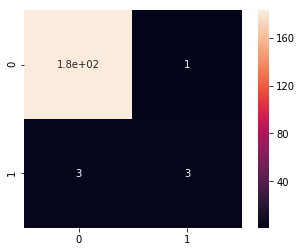

In [819]:
clf_tree = tree.DecisionTreeClassifier(max_depth=70)
clf_tree.fit(X_train_cv, Y_train)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# DecisionTree + ROS

             precision    recall  f1-score   support

          0     0.9733    0.9891    0.9811       184
          1     0.3333    0.1667    0.2222         6

avg / total     0.9531    0.9632    0.9572       190



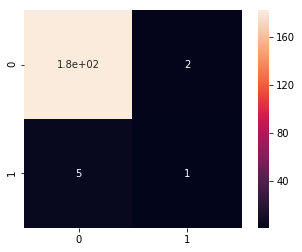

In [820]:
ros = RandomOverSampler()
X_ros_res, y_ros_res = ros.fit_sample(X_train_cv, Y_train)
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_ros_res, y_ros_res)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# DecisionTree + SMOTE

             precision    recall  f1-score   support

          0     0.9728    0.9728    0.9728       184
          1     0.1667    0.1667    0.1667         6

avg / total     0.9474    0.9474    0.9474       190



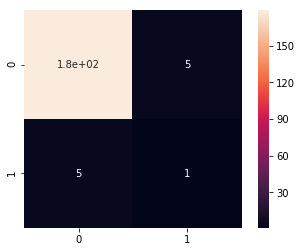

In [821]:
s = SMOTE()
X_s_res, y_s_res = s.fit_sample(X_train_cv, Y_train)
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_s_res, y_s_res)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# Decisiontree + ADASYN

             precision    recall  f1-score   support

          0     0.9727    0.9674    0.9700       184
          1     0.1429    0.1667    0.1538         6

avg / total     0.9465    0.9421    0.9443       190



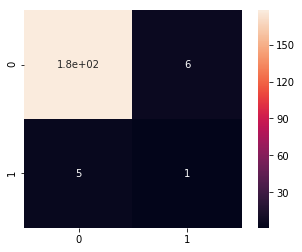

In [822]:
ada = ADASYN()
X_ada_res, y_ada_res = ada.fit_sample(X_train_cv, Y_train)
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_ada_res, y_ada_res)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# DecisionTree + RandomUnderSampler

             precision    recall  f1-score   support

          0     0.9924    0.7065    0.8254       184
          1     0.0847    0.8333    0.1538         6

avg / total     0.9637    0.7105    0.8042       190



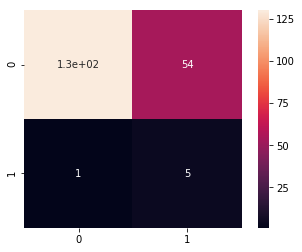

In [823]:
rus = RandomUnderSampler()
X_rus_res, y_rus_res = rus.fit_sample(X_train_cv, Y_train)
clf_tree = tree.DecisionTreeClassifier()
clf_tree.fit(X_rus_res, y_rus_res)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# RandomForestTree

             precision    recall  f1-score   support

          0     0.9684    1.0000    0.9840       184
          1     0.0000    0.0000    0.0000         6

avg / total     0.9378    0.9684    0.9529       190



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


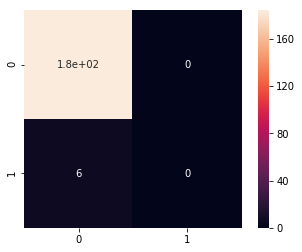

In [824]:
clf_rdm_tree = RandomForestClassifier(n_estimators=75, max_depth=50)
clf_rdm_tree.fit(X_train_cv, Y_train)
y_pred_rdmForest = clf_rdm_tree.predict(X_test_cv)
myEvaluation(y_pred_rdmForest)

# AdaBoostTree

             precision    recall  f1-score   support

          0     0.9786    0.9946    0.9865       184
          1     0.6667    0.3333    0.4444         6

avg / total     0.9688    0.9737    0.9694       190



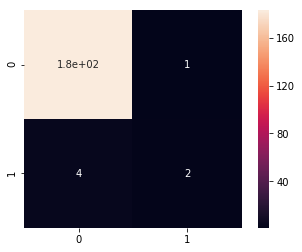

In [825]:
clf_adaBoost_tree = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=25),
                         algorithm="SAMME",
                         n_estimators=75)

clf_adaBoost_tree.fit(X_train_cv, Y_train)
y_pred_adaBoost = clf_adaBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_adaBoost)

# GradientBoostingTree

             precision    recall  f1-score   support

          0     0.9839    0.9946    0.9892       184
          1     0.7500    0.5000    0.6000         6

avg / total     0.9765    0.9789    0.9769       190



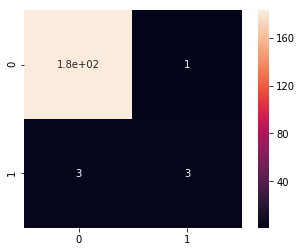

In [826]:
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=250, learning_rate=0.1, max_depth=75)
clf_gradBoost_tree.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9786    0.9946    0.9865       184
          1     0.6667    0.3333    0.4444         6

avg / total     0.9688    0.9737    0.9694       190



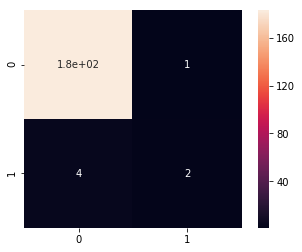

In [827]:
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=75, learning_rate=0.1, max_depth=50)
clf_gradBoost_tree.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9786    0.9946    0.9865       184
          1     0.6667    0.3333    0.4444         6

avg / total     0.9688    0.9737    0.9694       190



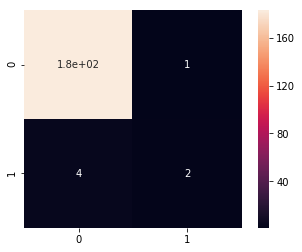

In [828]:
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=50)
clf_gradBoost_tree.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9786    0.9946    0.9865       184
          1     0.6667    0.3333    0.4444         6

avg / total     0.9688    0.9737    0.9694       190



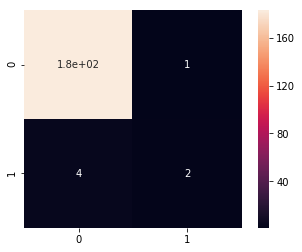

In [829]:
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=75)
clf_gradBoost_tree.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9839    0.9946    0.9892       184
          1     0.7500    0.5000    0.6000         6

avg / total     0.9765    0.9789    0.9769       190



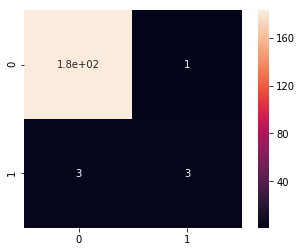

In [830]:
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=100)
clf_gradBoost_tree.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9839    0.9946    0.9892       184
          1     0.7500    0.5000    0.6000         6

avg / total     0.9765    0.9789    0.9769       190



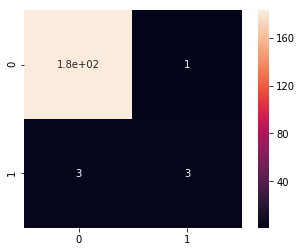

In [831]:
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=40)
clf_gradBoost_tree.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9839    0.9946    0.9892       184
          1     0.7500    0.5000    0.6000         6

avg / total     0.9765    0.9789    0.9769       190



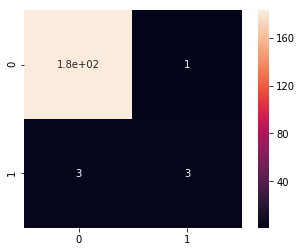

In [832]:
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=30)
clf_gradBoost_tree.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9786    0.9946    0.9865       184
          1     0.6667    0.3333    0.4444         6

avg / total     0.9688    0.9737    0.9694       190



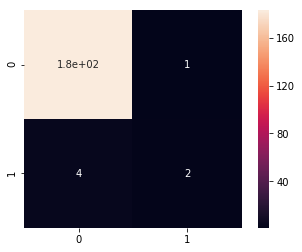

In [833]:
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=20)
clf_gradBoost_tree.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

# GradientBoostingTree + ROS

             precision    recall  f1-score   support

          0     1.0000    0.6848    0.8129       184
          1     0.0938    1.0000    0.1714         6

avg / total     0.9714    0.6947    0.7926       190



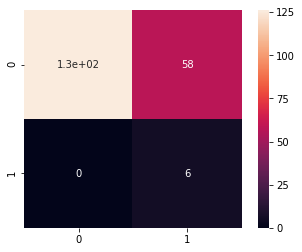

In [834]:
ros = RandomOverSampler()
X_ros_res, y_ros_res = ros.fit_sample(X_train_cv, Y_train)
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=75, learning_rate=0.1, max_depth=50)
clf_gradBoost_tree.fit(X_rus_res, y_rus_res)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

# GradientBoostingTree + RUS

             precision    recall  f1-score   support

          0     0.9823    0.6033    0.7475       184
          1     0.0519    0.6667    0.0964         6

avg / total     0.9529    0.6053    0.7269       190



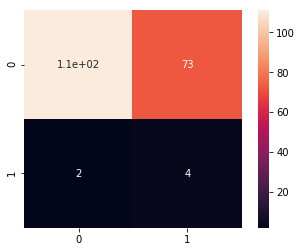

In [835]:
rus = RandomUnderSampler()
X_rus_res, y_rus_res = rus.fit_sample(X_train_cv, Y_train)
clf_gradBoost_tree = GradientBoostingClassifier(n_estimators=75, learning_rate=0.1, max_depth=30)
clf_gradBoost_tree.fit(X_rus_res, y_rus_res)
y_pred_gradBoost = clf_gradBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)